# Machine Learning: DDoS Classification with XGBOOST 

Distributed Denial of Service (DDoS) is one of the big concerns for cyber security. Similar to most of the vectorsin cyber crimes, characteristics and features of DDoS are dynamic. To identify such DDoS attack, Machine Learning has been one of the most successful approaches. The purpose of this article is to introduce DDoS problem and apply Machine Learnig techniques to identify attack. 

## Table of Contents

1. [Introduction and Problem Statement](#introall)  
    1.1 [Introduction](#intro)   
    1.2 [Problem Statement](#problem)  
2. [Data](#data)  
    2.1 [Import Data](#import)  
    2.2 [Data Exploration](#explore)  
    2.3 [Data Analysis](#analysis) 
3. [Result](#result)

## Introduction and Problem Statement<a id="introall"></a>

Even though DDoS is well known cyber security issue for long time, we are still looking for better approaches to tackle it. In current example, I have taken a simple but robust dataset, UNSW_NB15, in the domain and applied various methods of machine learning in the data. Further detail of the dataset can be found at: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/


The UNSW_NB15 data contains already separated training and testing data. I will work on the training dataset. The dataset provides features responsible for different types of cyber event. One of the event is DDoS event. As a target the present dataset provides attack category "attack_cat" and "label". In this I focus on classification of "label". In next article I will present "attack_cat" classification. 

This article was written for learning purpose and it focuses on a classification method, XGBOOST. 


## Data<a id="data"></a>

### Import Libraries & Data<a id="import"></a>

In [1]:
#Libraries

import numpy as np
import pandas as pd

import seaborn as sns
import scikitplot
import matplotlib.pyplot as plt
%matplotlib inline

#Data visualization, correlation plt
from pandas.plotting import scatter_matrix

#Random number generator, shuffling
import random
from sklearn.utils import shuffle


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost.sklearn import XGBClassifier
import xgboost
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools

#Plotting tree structure
from xgboost import plot_tree

#Feature Selection
from sklearn.feature_selection import RFECV


#Data was imported from https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/

traindf= pd.read_csv("UNSW_NB15_training-set.csv") #Main training data set
testdf= pd.read_csv("UNSW_NB15_testing-set.csv") #Main test data set

In [3]:
scikitplot.__version__

'0.3.7'

"traindf" and "testdf" are two dataframes.

## EDA<a id="explore"></a>

In [87]:
print(traindf)

          id       dur   proto   service state  spkts  dpkts  sbytes  dbytes  \
4757    4758  0.000008  ipcomp         -   INT      2      0     200       0   
57690  57691  0.000007     udp       dns   INT      2      0     114       0   
51478  51479  0.000001     udp       dns   INT      2      0     114       0   
65027  65028  1.161573     tcp         -   FIN     10     10     824    1520   
56285  56286  0.000012     udp       dns   INT      2      0     114       0   
17193  17194  0.000009     udp       dns   INT      2      0     114       0   
20418  20419  0.000005     udp       dns   INT      2      0     114       0   
60275  60276  1.059992     tcp         -   FIN     10      8     538     354   
65454  65455  0.616043     tcp         -   FIN     12      8    1068     756   
17170  17171  0.000005     udp       dns   INT      2      0     114       0   
9643    9644  0.232151     tcp      http   FIN     10      6     866     268   
47302  47303  0.664457     tcp  ftp-data

In [90]:
def display_header(df):
    '''
    Input: Dataframe (df)
    Prints shape (rows, columns of data frame
    Displays header of the df
    '''
    print ("\n\n Rows ={}, Cols ={} \n\n ".format(df.shape[0],df.shape[1] ))
    print(df.head())
    
def display_description(df):
    '''
    Input: Dataframe (df)
    Prints shape (rows, columns of data frame
    Displays statistical description  of the df
    
    Other informations like numerical and categorical variables and number of unique features are also printed
    '''
    print ("\n\n Rows ={}, Cols ={} \n\n".format(df.shape[0],df.shape[1] ))
    print (df.describe(include='all'))
    
    #List all features of the trainging data
    print(list(df))
    
    #Know type (numerical or categorical or integer) of each variable
    #traindf.info()

    #Print just categorical variables
    cat_features = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]
    print (cat_features)
    #Print just numerical variables
    num_features = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['int64', 'float64']]

    print (num_features)

    #How many unique elements are there

    print(df.nunique())

def display_nan_inormation(df):
    '''
    Input: Dataframe (df)
    Prints shape (rows, columns of data frame
    Displays nan description  of the df
    '''
    print ("\n\n Rows ={}, Cols ={} \n\n".format(df.shape[0],df.shape[1] ))
    print (df.isnull().sum())

display_header(traindf)
display_description(traindf)
display_nan_inormation(traindf)




 Rows =74000, Cols =45 

 
             id       dur  proto service state  spkts  dpkts  sbytes  dbytes  \
60085  0.756292 -0.216300    udp     dns   INT      2      0     114       0   
11423 -1.295882  4.541173   ospf       -   INT     20      0    1280       0   
49298  0.301382 -0.216302  ipnip       -   INT      2      0     180       0   
9908  -1.359773 -0.051748    tcp       -   FIN     10      8     564     354   
11662 -1.285803 -0.045658    tcp    http   FIN     18     10   12600    1150   

                rate  ...    ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
60085   90909.090200  ...                   3               7             0   
11423       0.861745  ...                   1               1             0   
49298  250000.000600  ...                   4               4             0   
9908       22.291545  ...                   1               1             0   
11662      34.140699  ...                   1               1             0   

       ct_ftp_c

### NAN Handling

In [85]:
def fill_nan(df,feature_wNaN):
    '''
    Input Data Frame
    Fill NaN values in designated columns by appropriate values
    Return dataFrame
    '''
    
    trainData[feature_wNaN]=trainData[feature_wNaN].fillna(method='ffill')
    #See fillna for other bfill, and other options
    
    return df

def drop_nan(df):
    '''
    Inputs Data Frame (df)
    If any NaN value is present in any column and any row,
    remove the entire row
    Returns Data Frame
    ''' 
    df= df.dropna()
    return df

nan_cols = traindf.columns[traindf.isna().any()].tolist()

if len(nan_cols):
    for feature_wNaN in nan_cols:
        fill_nan(traindf,feature_wNaN)
        drop_nan(traindf)
    

### Data balancing

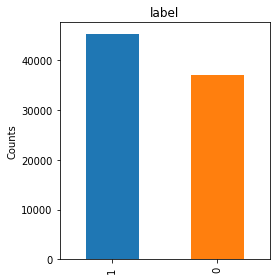

1    45332
0    37000
Name: label, dtype: int64
{1: 45332, 0: 37000}
Minority Class :   0 37000
Majority Class :   1 45332
1    37000
0    37000
Name: label, dtype: int64


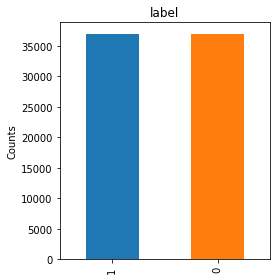

In [86]:
def display_target_graphically(df, var_of_interest):
    '''
    Input: Data Frame df
    It plots distribution of target variable
    '''
    plt.subplot(1,1, 1)
    df[var_of_interest].value_counts().plot(kind='bar',figsize=(4,4))
    plt.title(var_of_interest)
    plt.ylabel('Counts')
    plt.tight_layout()
    plt.show()
    
#Resampling up/down sampling
from sklearn.utils import resample  
def balance_data(df,target):
    '''
    This method works good for binary classes of target
    '''
    print(df[target].value_counts())
    
    #Dictionary of values
    d =df[target].value_counts().to_dict()
    print(d)
    max_val =-float("inf")
    max_key = -float("inf")
    for key, value in d.items():
        if value >max_val:
            max_val= value
            max_key = key
    
    min_val =float("inf")
    min_key = float("inf")
    for key, value in d.items():
        if value <min_val:
            min_val= value
            min_key = key
    
    print("Minority Class :  ", min_key, min_val)
    print("Majority Class :  ", max_key, max_val)
        
    
    # Separate majority and minority classes
    df_majority = df[df[target]==max_key]
    df_minority = df[df[target]==min_key]
    
   
    #Downsample majority class
    df_majority_downsampled = resample(df_majority,
                               replace=False,    # sample without replacement
                               n_samples=min_val,     # to match minority class, you can change min_val to other value
                               random_state=123) # reproducible results
 

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
    # Display new class counts
    print(df_downsampled[target].value_counts())
    
    return df_downsampled

    
    
display_target_graphically(traindf,'label')
#If balancing is necessary, uncomment line below
traindf = balance_data(traindf,'label')
display_target_graphically(traindf,'label')

### Observe Correlations

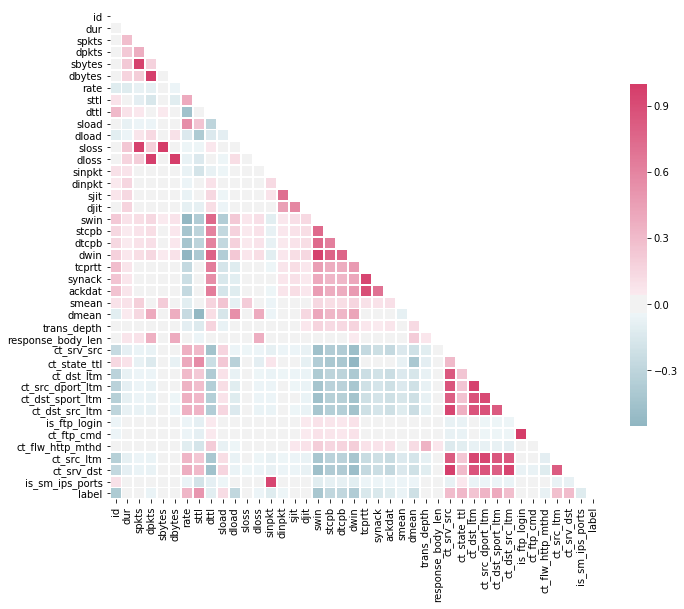

In [93]:
def compute_correlations(df):
    # Compute the correlation matrix

    #Alternative quick way:
    #Heatmap of correlation for continuous variables

    #sns.heatmap(traindf.corr())

    #It takes a little while to plot, but its inoformation is useful in many cases
    #scatter_matrix(df, alpha=0.2, figsize=(10,10), diagonal='kde', s=200)

    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 0, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.9, cbar_kws={"shrink": .7})

compute_correlations(traindf)

###  Randomize and Scale Data

In [92]:
def randomize_data(df):
    
    '''
    Input : Data Frame (df)
    Randomizes the rows 
    Returns: Data Frame
    '''
    df = shuffle(df)
    #Alternatively: 
    #df=df.sample(frac=1)
    return df


def scale_data(df):
    
    '''
    Input : Data Frame (df)
    Scale data using formula: (data-data.min())/data.max()
    or
    Scale data using formula: (data-data.mean())/data.std()
    Return: Scaled Data Frame
    '''
    num_features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
                    'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 
                    'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack',
                    'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len',
                    'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm',
                    'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd',
                    'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']
    
    for i in num_features[:-1]: #Not including the last categoty 'label'
        #(data-min)/max
        # df[i] -= df[i].min()  
        # df[i] /= df[i].max()
       
        #(data-mean())/sd
        df[i] = (df[i] - df[i].mean()) / (df[i].std())   # standardization
     
    return df

traindf = randomize_data(traindf)
traindf = scale_data(traindf)



### Identify Highly Correlated Features

In [95]:
def highly_correlated_features(df):
    #Print highly correlated features.  In some ML models, we must remove(drop) such highly correlated features
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    print (to_drop)

    #In our optimization we will revisit if dropping these features makes difference in prediction.
    #Choosing a right threshold (instead of 0.95) is also a matter of parameter optimization

highly_correlated_features(traindf)

['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_ftp_cmd', 'ct_srv_dst']


###  Visualization of Numerical and Cetegorical variables

In [96]:
 def display_distribution_of_categorical_vars(df):
    #See the distribution of all categorical variables
    plt.subplot(4,1, 1)
    df[cat_features[0]].value_counts().plot(kind='bar',figsize=(16,16))
    plt.title(cat_features[0])
    
    plt.subplot(4,1, 2)
    df[cat_features[1]].value_counts().plot(kind='bar',figsize=(16,16))
    plt.title(cat_features[1])
    
    plt.subplot(4,1, 3)
    df[cat_features[2]].value_counts().plot(kind='bar',figsize=(16,16))
    plt.title(cat_features[2])
    
    plt.subplot(4,1, 4)
    df[cat_features[3]].value_counts().plot(kind='bar',figsize=(16,16))
    plt.title(cat_features[3])
    
    
    plt.tight_layout()
    plt.show()


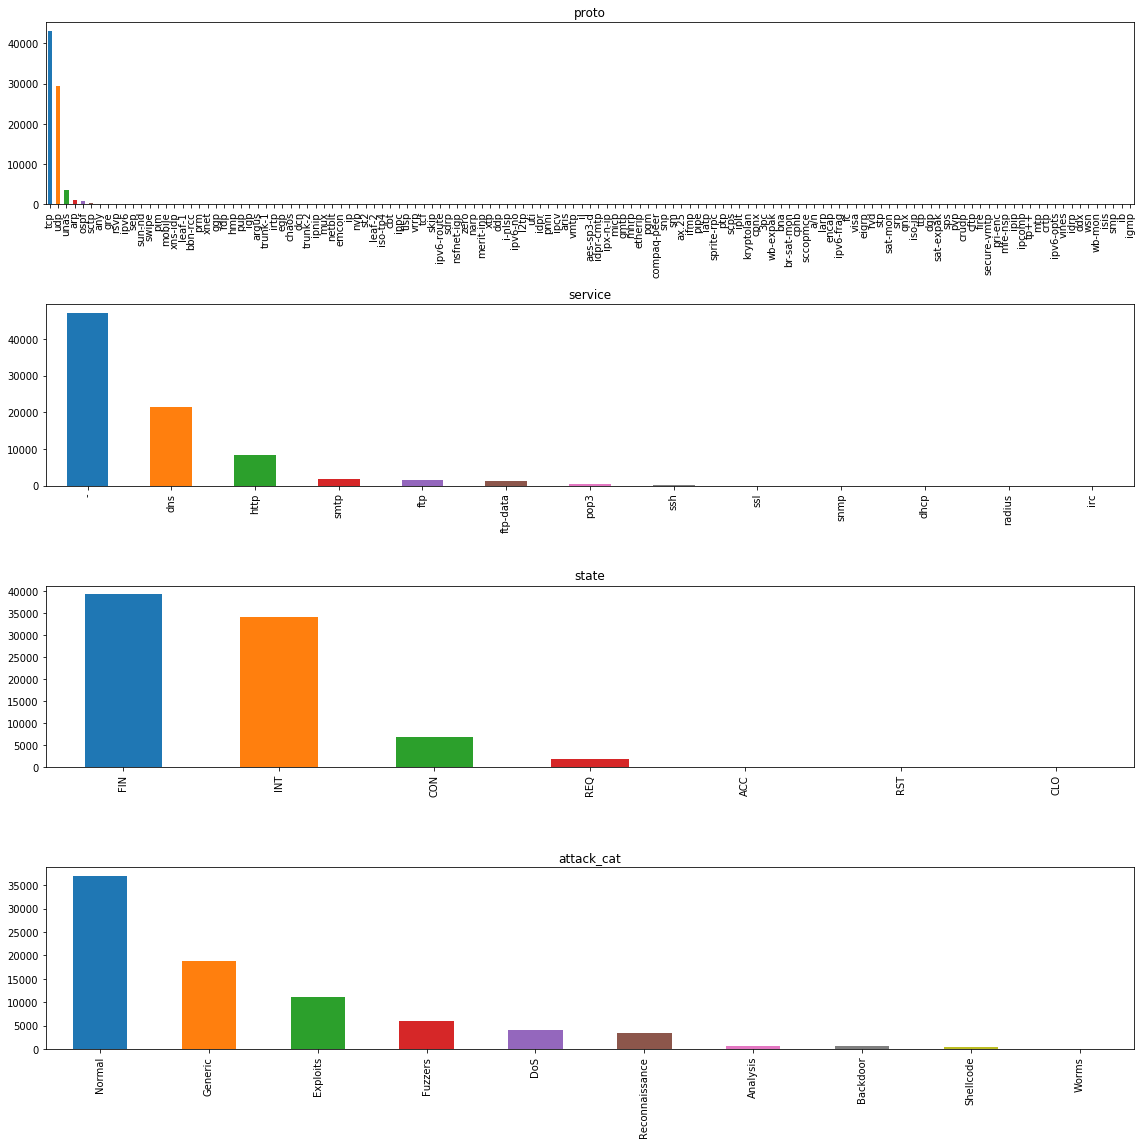

In [287]:
display_distribution_of_categorical_vars(traindf)     

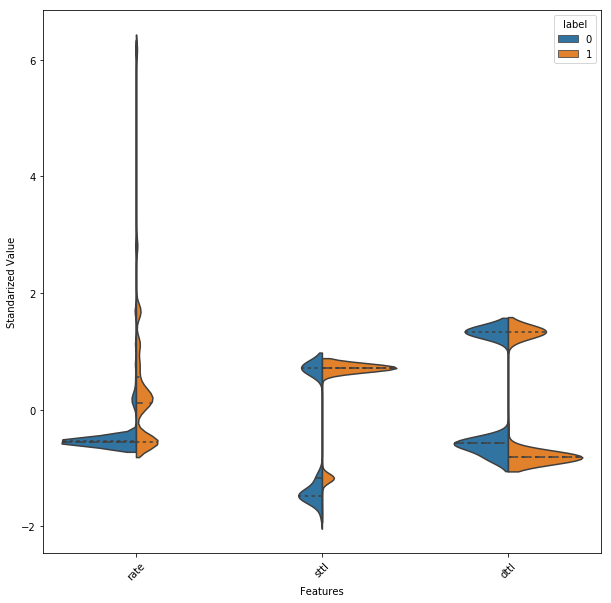

In [288]:
def display_boxplots_of_vars(df,first,last):
    """
    Input: Data Frame df with index values first and last
    Takes all numerical features and target 
    Creates box plot for both category of 'label' variable
    """
    num_features =df[['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate',\
                      'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',\
                      'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',\
                      'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len',\
                      'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',\
                      'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',\
                      'ct_srv_dst', 'is_sm_ips_ports']]
    y= df[['label']]

    data = num_features
    data = pd.concat([y,data.iloc[:,first:last]],axis=1) #Choose first and last value while calling this function
    data = pd.melt(data,id_vars="label",
                    var_name="Features",
                    value_name='Standarized Value')
    plt.figure(figsize=(10,10))
    #sns.boxplot(x="Features", y="Standarized Value", hue="label", data=data)
    sns.violinplot(x="Features", y="Standarized Value", hue="label", data=data,split=True, inner="quart")
    plt.xticks(rotation=45)
    
display_boxplots_of_vars(traindf,5,8)


Violen Plot for three features "rate", "sttl" and "dttl". In the plot distributions of '0' and '1' labelled quantities are shown in blue and orange. The orange and blue are not mirror images indocating that the classification is possible with higher accuracy

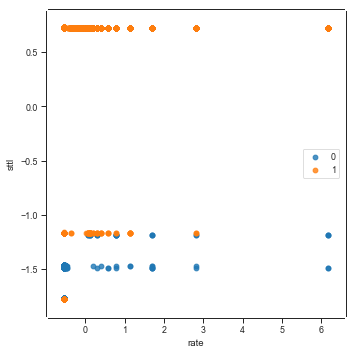

In [316]:
def DoS_vis(data, feature1, feature2):
    

    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("paper")
    # Use the 'hue' argument to provide a factor variable
    sns.lmplot( x=feature1, y=feature2, data=data, fit_reg=False, hue='label', legend=False,height=5)
 
    # Move the legend to an empty part of the plot
    plt.legend(loc='center right')
    sns.despine(offset=2, trim=False,right=False, top=False)
    
DoS_vis(traindf,'rate','sttl')

One of the example of scatter plot. Choose other feature of interest to see other scatter plots. 

## Data Analysis <a id="analysis"></a> 

### Create Dummy Variables 

In [129]:
def sep_feat_target_and_dummy_cat(df):
    '''
    Input: Data Frame df
    First it separates feature matrix X and target vector y
    Creates dummies of each categorical variable
    Reurns: two data frames : Feature matrix (X) and target matrix y
    '''
    #Separate feature matrix (X) and target(y)
    y= df.loc[:,'label']
    X= df.drop(['attack_cat','label','id'], axis=1)
    #Creat dummies for categorical variables
    X= pd.get_dummies(X)  #Note that: in this configuration, it doesn't drop a category!
    
    return X,y

feat_mat, target = sep_feat_target_and_dummy_cat(traindf)


### Train Test Split

In [131]:
def train_test_splitting(feat_mat,target):
    X_train, X_test, y_train, y_test = train_test_split(feat_mat, target, test_size=0.20, random_state=12)
    
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_splitting(feat_mat,target)

In [142]:
def xgb_basic_classifier(X_train,y_train):
    #Parameter Tuning:

    #1. Start using default parameters
    XGB = XGBClassifier()
    trained = XGB.fit(X_train,y_train)
    
    return trained
xgb_basic_model = xgb_basic_classifier(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
accuracy: 0.961
[[7029  288]
 [ 355 8795]]


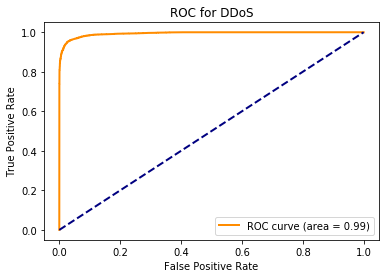

In [147]:
print (xgb_basic_model)
# Compute ROC curve and ROC area for each class
y_test_pred = xgb_basic_model.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
print('accuracy: %.3f'%(acc))
cm = confusion_matrix(y_test, y_test_pred)
print(cm)


fpr, tpr, _ = roc_curve(y_test, xgb_basic_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for DDoS')
plt.legend(loc="lower right")
plt.show()

## Optimization

### Grid Search

In [221]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from xgboost.sklearn import XGBClassifier

param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=10, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5,return_train_score=True)

gsearch1.fit(X_train,y_train)
print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)


{'mean_fit_time': array([3.56882792, 2.41987438, 2.67852135, 4.07333355, 3.81085882,
       3.95194736, 8.45281353, 7.58217812, 8.26994085, 7.66289296,
       7.8570755 , 8.62389131]), 'std_fit_time': array([0.56100899, 0.05722768, 0.18023607, 0.05526911, 0.12951388,
       0.13860965, 2.32838406, 1.38315556, 1.66178501, 1.43676907,
       1.3098818 , 1.65292731]), 'mean_score_time': array([0.10849295, 0.0878407 , 0.0978117 , 0.08096299, 0.08420806,
       0.09012341, 0.09280605, 0.10050402, 0.07374792, 0.07696915,
       0.12529602, 0.07755561]), 'std_score_time': array([0.01225998, 0.01576325, 0.00764735, 0.01175635, 0.01419151,
       0.01547984, 0.01098349, 0.02369721, 0.00418855, 0.00438084,
       0.06621508, 0.0118115 ]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_ch

In [222]:
print('\n All results:')
print(gsearch1.cv_results_)
print('\n Best estimator:')
print(gsearch1.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:')
print(gsearch1.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(gsearch1.best_params_)
results = pd.DataFrame(gsearch1.cv_results_)
print(results)


 All results:
{'mean_fit_time': array([3.56882792, 2.41987438, 2.67852135, 4.07333355, 3.81085882,
       3.95194736, 8.45281353, 7.58217812, 8.26994085, 7.66289296,
       7.8570755 , 8.62389131]), 'std_fit_time': array([0.56100899, 0.05722768, 0.18023607, 0.05526911, 0.12951388,
       0.13860965, 2.32838406, 1.38315556, 1.66178501, 1.43676907,
       1.3098818 , 1.65292731]), 'mean_score_time': array([0.10849295, 0.0878407 , 0.0978117 , 0.08096299, 0.08420806,
       0.09012341, 0.09280605, 0.10050402, 0.07374792, 0.07696915,
       0.12529602, 0.07755561]), 'std_score_time': array([0.01225998, 0.01576325, 0.00764735, 0.01175635, 0.01419151,
       0.01547984, 0.01098349, 0.02369721, 0.00418855, 0.00438084,
       0.06621508, 0.0118115 ]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object)

In [214]:
print(gsearch1)
gsearch1.score(X_test, y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


0.9980569607658583

In [215]:
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)
trained = XGB.fit(X_train,y_train)
trained.score(X_test, y_test)

0.97971700977713

In [223]:
param_test2 = {
    'n_estimators':range(1,1001,100)
    
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=10, max_depth=9,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5,return_train_score=True)

gsearch2.fit(X_train,y_train)
print(gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_)



{'mean_fit_time': array([  4.96698012, 106.50604639, 138.11349754, 192.39955888,
       237.59891381, 267.92153077, 314.75951095, 372.76005878,
       436.22520556, 481.77439761]), 'std_fit_time': array([ 0.59353006, 20.17045257, 12.79118845, 21.32512174,  5.2226759 ,
        3.89371983,  1.92790551,  4.48356221,  3.24289469, 14.44320675]), 'mean_score_time': array([0.23478122, 0.20918436, 0.48870668, 0.70472975, 0.9149652 ,
       1.00913143, 1.25577564, 1.45744214, 1.80505905, 1.79596815]), 'std_score_time': array([0.01168569, 0.02856276, 0.01901083, 0.21807768, 0.1483267 ,
       0.02316933, 0.0289338 , 0.03495651, 0.02242755, 0.17655553]), 'param_n_estimators': masked_array(data=[1, 101, 201, 301, 401, 501, 601, 701, 801, 901],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 1}, {'n_estimators': 101}, {'n_estimators': 201}, {'n_estimators': 301}

In [224]:
print('\n All results:')
print(gsearch2.cv_results_)
print('\n Best estimator:')
print(gsearch2.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:')
print(gsearch2.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(gsearch2.best_params_)
results = pd.DataFrame(gsearch2.cv_results_)
print(results)


 All results:
{'mean_fit_time': array([  4.96698012, 106.50604639, 138.11349754, 192.39955888,
       237.59891381, 267.92153077, 314.75951095, 372.76005878,
       436.22520556, 481.77439761]), 'std_fit_time': array([ 0.59353006, 20.17045257, 12.79118845, 21.32512174,  5.2226759 ,
        3.89371983,  1.92790551,  4.48356221,  3.24289469, 14.44320675]), 'mean_score_time': array([0.23478122, 0.20918436, 0.48870668, 0.70472975, 0.9149652 ,
       1.00913143, 1.25577564, 1.45744214, 1.80505905, 1.79596815]), 'std_score_time': array([0.01168569, 0.02856276, 0.01901083, 0.21807768, 0.1483267 ,
       0.02316933, 0.0289338 , 0.03495651, 0.02242755, 0.17655553]), 'param_n_estimators': masked_array(data=[1, 101, 201, 301, 401, 501, 601, 701, 801, 901],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 1}, {'n_estimators': 101}, {'n_estimators': 201}, {'n_es

### Randomized Search

In [138]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [139]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from datetime import datetime
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=401,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)
# A parameter grid for XGBoost
params = {
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        }

folds = 3  #Increase folds to 5 or more
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb,
                                   scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train),
                                   verbose=3, random_state=1001,return_train_score=True )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 12.5min finished



 Time taken: 0 hours 16 minutes and 27.46 seconds.


In [140]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:'% (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
print(results)


 All results:
{'mean_fit_time': array([173.68089072, 172.13822937, 202.26153612, 185.05510028,
       182.603127  ]), 'std_fit_time': array([ 0.31550244,  0.5133485 , 14.49235138,  1.55460364,  1.90524718]), 'mean_score_time': array([1.19984094, 0.92058961, 1.38493705, 1.35054032, 1.0050842 ]), 'std_score_time': array([0.01555629, 0.00963133, 0.07448025, 0.24624321, 0.07197919]), 'param_subsample': masked_array(data=[0.8, 0.8, 0.6, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.5, 2, 0.5, 0.5, 1.5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'subsample': 0.8, 'gamma': 0.5}, {'subsample': 0.8, 'gamma': 2}, {'subsample': 0.6, 'gamma': 0.5}, {'subsample': 1.0, 'gamma': 0.5}, {'subsample': 0.8, 'gamma': 1.5}], 'split0_test_score': array([0.99759322, 0.99759228, 0.99742527, 0.99774261, 0.997599  ]), 'split1_test_s

### Error Analysis

In [252]:
# monitor training performance
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=405,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1.0)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.042449
[1]	validation_0-error:0.040505
[2]	validation_0-error:0.036315
[3]	validation_0-error:0.036254
[4]	validation_0-error:0.035586
[5]	validation_0-error:0.034493
[6]	validation_0-error:0.03425
[7]	validation_0-error:0.032914
[8]	validation_0-error:0.031882
[9]	validation_0-error:0.032003
[10]	validation_0-error:0.031639
[11]	validation_0-error:0.031214
[12]	validation_0-error:0.030789
[13]	validation_0-error:0.030607
[14]	validation_0-error:0.031396
[15]	validation_0-error:0.03085
[16]	validation_0-error:0.030303
[17]	validation_0-error:0.03006
[18]	validation_0-error:0.029878
[19]	validation_0-error:0.029392
[20]	validation_0-error:0.028542
[21]	validation_0-error:0.027995
[22]	validation_0-error:0.028056
[23]	validation_0-error:0.027752
[24]	validation_0-error:0.027327
[25]	validation_0-error:0.027449
[26]	validation_0-error:0.027267
[27]	validation_0-error:0.027084
[28]	validation_0-error:0.027024
[29]	validation_0-error:0.026963
[30]	validation_0-error

[246]	validation_0-error:0.020162
[247]	validation_0-error:0.020101
[248]	validation_0-error:0.020222
[249]	validation_0-error:0.020344
[250]	validation_0-error:0.020404
[251]	validation_0-error:0.020283
[252]	validation_0-error:0.020283
[253]	validation_0-error:0.020283
[254]	validation_0-error:0.020283
[255]	validation_0-error:0.020344
[256]	validation_0-error:0.020344
[257]	validation_0-error:0.020587
[258]	validation_0-error:0.020526
[259]	validation_0-error:0.020465
[260]	validation_0-error:0.020404
[261]	validation_0-error:0.020587
[262]	validation_0-error:0.020647
[263]	validation_0-error:0.020465
[264]	validation_0-error:0.020465
[265]	validation_0-error:0.020526
[266]	validation_0-error:0.020526
[267]	validation_0-error:0.020587
[268]	validation_0-error:0.020647
[269]	validation_0-error:0.020647
[270]	validation_0-error:0.020647
[271]	validation_0-error:0.020587
[272]	validation_0-error:0.020526
[273]	validation_0-error:0.020526
[274]	validation_0-error:0.020526
[275]	validati

[0]	validation_0-error:0.037759	validation_0-logloss:0.610043	validation_1-error:0.042449	validation_1-logloss:0.610627
[1]	validation_0-error:0.036438	validation_0-logloss:0.542229	validation_1-error:0.040505	validation_1-logloss:0.543245
[2]	validation_0-error:0.032779	validation_0-logloss:0.484682	validation_1-error:0.036315	validation_1-logloss:0.486309
[3]	validation_0-error:0.03243	validation_0-logloss:0.437679	validation_1-error:0.036254	validation_1-logloss:0.439263
[4]	validation_0-error:0.031974	validation_0-logloss:0.39589	validation_1-error:0.035586	validation_1-logloss:0.397865
[5]	validation_0-error:0.030805	validation_0-logloss:0.362138	validation_1-error:0.034493	validation_1-logloss:0.364619
[6]	validation_0-error:0.03035	validation_0-logloss:0.330431	validation_1-error:0.03425	validation_1-logloss:0.333194
[7]	validation_0-error:0.028953	validation_0-logloss:0.302116	validation_1-error:0.032914	validation_1-logloss:0.305251
[8]	validation_0-error:0.028619	validation_0

[69]	validation_0-error:0.018052	validation_0-logloss:0.057527	validation_1-error:0.023562	validation_1-logloss:0.065304
[70]	validation_0-error:0.017976	validation_0-logloss:0.05732	validation_1-error:0.023562	validation_1-logloss:0.065147
[71]	validation_0-error:0.017946	validation_0-logloss:0.056905	validation_1-error:0.023319	validation_1-logloss:0.064749
[72]	validation_0-error:0.017961	validation_0-logloss:0.056823	validation_1-error:0.023259	validation_1-logloss:0.064681
[73]	validation_0-error:0.017794	validation_0-logloss:0.05613	validation_1-error:0.022955	validation_1-logloss:0.064157
[74]	validation_0-error:0.017748	validation_0-logloss:0.055876	validation_1-error:0.023137	validation_1-logloss:0.064002
[75]	validation_0-error:0.017384	validation_0-logloss:0.054767	validation_1-error:0.022712	validation_1-logloss:0.063257
[76]	validation_0-error:0.017293	validation_0-logloss:0.054366	validation_1-error:0.022651	validation_1-logloss:0.063051
[77]	validation_0-error:0.017293	v

[137]	validation_0-error:0.010552	validation_0-logloss:0.035344	validation_1-error:0.02083	validation_1-logloss:0.055196
[138]	validation_0-error:0.010491	validation_0-logloss:0.035161	validation_1-error:0.021012	validation_1-logloss:0.055046
[139]	validation_0-error:0.010491	validation_0-logloss:0.035064	validation_1-error:0.021072	validation_1-logloss:0.055034
[140]	validation_0-error:0.010461	validation_0-logloss:0.034984	validation_1-error:0.021072	validation_1-logloss:0.054989
[141]	validation_0-error:0.010461	validation_0-logloss:0.034915	validation_1-error:0.021072	validation_1-logloss:0.054954
[142]	validation_0-error:0.010385	validation_0-logloss:0.034663	validation_1-error:0.021072	validation_1-logloss:0.054925
[143]	validation_0-error:0.0104	validation_0-logloss:0.034647	validation_1-error:0.021072	validation_1-logloss:0.054931
[144]	validation_0-error:0.010339	validation_0-logloss:0.034483	validation_1-error:0.021012	validation_1-logloss:0.054758
[145]	validation_0-error:0.

[205]	validation_0-error:0.005496	validation_0-logloss:0.023937	validation_1-error:0.020647	validation_1-logloss:0.052941
[206]	validation_0-error:0.005451	validation_0-logloss:0.023865	validation_1-error:0.020587	validation_1-logloss:0.052932
[207]	validation_0-error:0.005451	validation_0-logloss:0.023844	validation_1-error:0.020587	validation_1-logloss:0.052908
[208]	validation_0-error:0.00542	validation_0-logloss:0.023819	validation_1-error:0.020587	validation_1-logloss:0.052869
[209]	validation_0-error:0.005375	validation_0-logloss:0.023753	validation_1-error:0.020526	validation_1-logloss:0.052875
[210]	validation_0-error:0.005375	validation_0-logloss:0.02373	validation_1-error:0.020526	validation_1-logloss:0.052844
[211]	validation_0-error:0.005177	validation_0-logloss:0.023457	validation_1-error:0.020526	validation_1-logloss:0.052815
[212]	validation_0-error:0.005147	validation_0-logloss:0.0233	validation_1-error:0.020465	validation_1-logloss:0.052808
[213]	validation_0-error:0.0

[273]	validation_0-error:0.002733	validation_0-logloss:0.016922	validation_1-error:0.020526	validation_1-logloss:0.052416
[274]	validation_0-error:0.002733	validation_0-logloss:0.016905	validation_1-error:0.020526	validation_1-logloss:0.052408
[275]	validation_0-error:0.002718	validation_0-logloss:0.016821	validation_1-error:0.020526	validation_1-logloss:0.052474
[276]	validation_0-error:0.002687	validation_0-logloss:0.01678	validation_1-error:0.020465	validation_1-logloss:0.052424
[277]	validation_0-error:0.002687	validation_0-logloss:0.016759	validation_1-error:0.020465	validation_1-logloss:0.052405
[278]	validation_0-error:0.002657	validation_0-logloss:0.016699	validation_1-error:0.020465	validation_1-logloss:0.052404
[279]	validation_0-error:0.002657	validation_0-logloss:0.016681	validation_1-error:0.020465	validation_1-logloss:0.052392
[280]	validation_0-error:0.002657	validation_0-logloss:0.01666	validation_1-error:0.020465	validation_1-logloss:0.052361
[281]	validation_0-error:0

[341]	validation_0-error:0.001473	validation_0-logloss:0.012972	validation_1-error:0.019615	validation_1-logloss:0.052439
[342]	validation_0-error:0.001473	validation_0-logloss:0.012965	validation_1-error:0.019554	validation_1-logloss:0.052451
[343]	validation_0-error:0.001488	validation_0-logloss:0.012909	validation_1-error:0.019494	validation_1-logloss:0.052466
[344]	validation_0-error:0.001488	validation_0-logloss:0.012867	validation_1-error:0.019494	validation_1-logloss:0.052475
[345]	validation_0-error:0.001488	validation_0-logloss:0.012819	validation_1-error:0.019736	validation_1-logloss:0.052468
[346]	validation_0-error:0.001458	validation_0-logloss:0.012725	validation_1-error:0.019858	validation_1-logloss:0.052495
[347]	validation_0-error:0.001442	validation_0-logloss:0.012664	validation_1-error:0.019797	validation_1-logloss:0.052514
[348]	validation_0-error:0.001412	validation_0-logloss:0.012604	validation_1-error:0.019979	validation_1-logloss:0.052542
[349]	validation_0-error

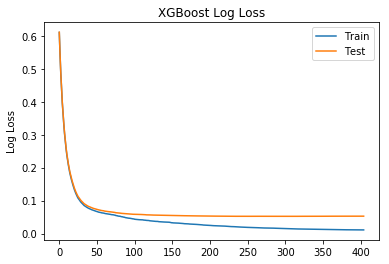

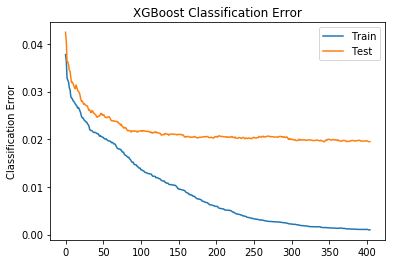

In [253]:
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load data

model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=405,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1.0)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [254]:
# early stopping
#XGBoost provides early stopping criteria. If the eval_metric doesn't improve in the steps provided
#in criteria then the model stops. 
#You need to manually update the n_estimators values in the model
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=405,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1.0)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.610627
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.543245
[2]	validation_0-logloss:0.486309
[3]	validation_0-logloss:0.439263
[4]	validation_0-logloss:0.397865
[5]	validation_0-logloss:0.364619
[6]	validation_0-logloss:0.333194
[7]	validation_0-logloss:0.305251
[8]	validation_0-logloss:0.281689
[9]	validation_0-logloss:0.260629
[10]	validation_0-logloss:0.241789
[11]	validation_0-logloss:0.226577
[12]	validation_0-logloss:0.212085
[13]	validation_0-logloss:0.199159
[14]	validation_0-logloss:0.187538
[15]	validation_0-logloss:0.177942
[16]	validation_0-logloss:0.168824
[17]	validation_0-logloss:0.160162
[18]	validation_0-logloss:0.152385
[19]	validation_0-logloss:0.145004
[20]	validation_0-logloss:0.138022
[21]	validation_0-logloss:0.131732
[22]	validation_0-logloss:0.126192
[23]	validation_0-logloss:0.12115
[24]	validation_0-logloss:0.116405
[25]	validation_0-logloss:0.112072
[26]	validation_0-logloss:0.10916

[230]	validation_0-logloss:0.052507
[231]	validation_0-logloss:0.052473
[232]	validation_0-logloss:0.052472
[233]	validation_0-logloss:0.052458
[234]	validation_0-logloss:0.05243
[235]	validation_0-logloss:0.052466
[236]	validation_0-logloss:0.052462
[237]	validation_0-logloss:0.052382
[238]	validation_0-logloss:0.052398
[239]	validation_0-logloss:0.052395
[240]	validation_0-logloss:0.05242
[241]	validation_0-logloss:0.052433
[242]	validation_0-logloss:0.052419
[243]	validation_0-logloss:0.052424
[244]	validation_0-logloss:0.052452
[245]	validation_0-logloss:0.052474
[246]	validation_0-logloss:0.052452
[247]	validation_0-logloss:0.052408
Stopping. Best iteration:
[237]	validation_0-logloss:0.052382

Accuracy: 97.97%


### Model Evaluation

In [264]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[7219  118]
 [ 216 8914]]
Normalized confusion matrix
[[0.98 0.02]
 [0.02 0.98]]


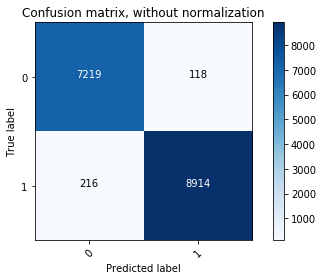

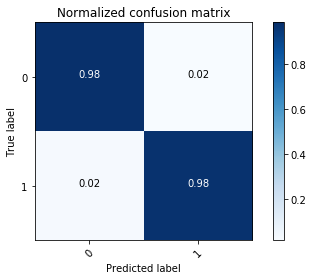

In [265]:
y_pred = model.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = [0,1]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy: 0.960
[[7042  295]
 [ 364 8766]]


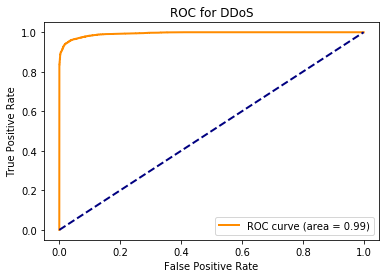

In [192]:

# Compute ROC curve and ROC area for each class
y_test_pred = XGB.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
print('accuracy: %.3f'%(acc))
cm = confusion_matrix(y_test, y_test_pred)
print(cm)


fpr, tpr, _ = roc_curve(y_test, XGB.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for DDoS')
plt.legend(loc="lower right")
plt.show()

In [169]:
def find_important_features(xgb_model)

    #This is how we extract the feature importance metrics from the fitted model.
    #Weight: The number of times a feature is used to split the data across all trees.
    #Cover: The number of times a feature is used to split the data across all trees weighted by
    #       the number of training data points that go through those splits.
    #Gain: The average training loss reduction gained when using a feature for splitting.

    #Feature importance fluctuates quite a bit with these Parameters: "Weight", "Gain" and "Cover"
    #I believe in the result. So I would measure precision, recall and accuracy to reject least 
    #important feature


    df_features = pd.DataFrame({'Weight': xgb_model.get_booster().get_score(importance_type='weight'),
                            'Gain': xgb_model.get_booster().get_score(importance_type='gain'),
                            'Cover': xgb_model.get_booster().get_score(importance_type='cover')},
                               index=X_train.columns)
    #df_features.sort_values('Cover', ascending=False).head(20)
    #df_features.sort_values('Gain', ascending=False).head(20)
    print(df_features.sort_values('Weight', ascending=False).head(20))
    
    # also a plotting function, it uses weight by default, which is why it is not very useful!
    fig, ax = plt.subplots(1,1,figsize=(8,21))
    xgboost.plot_importance(XGB, ax=ax)
#find_important_features(xgb_model)    

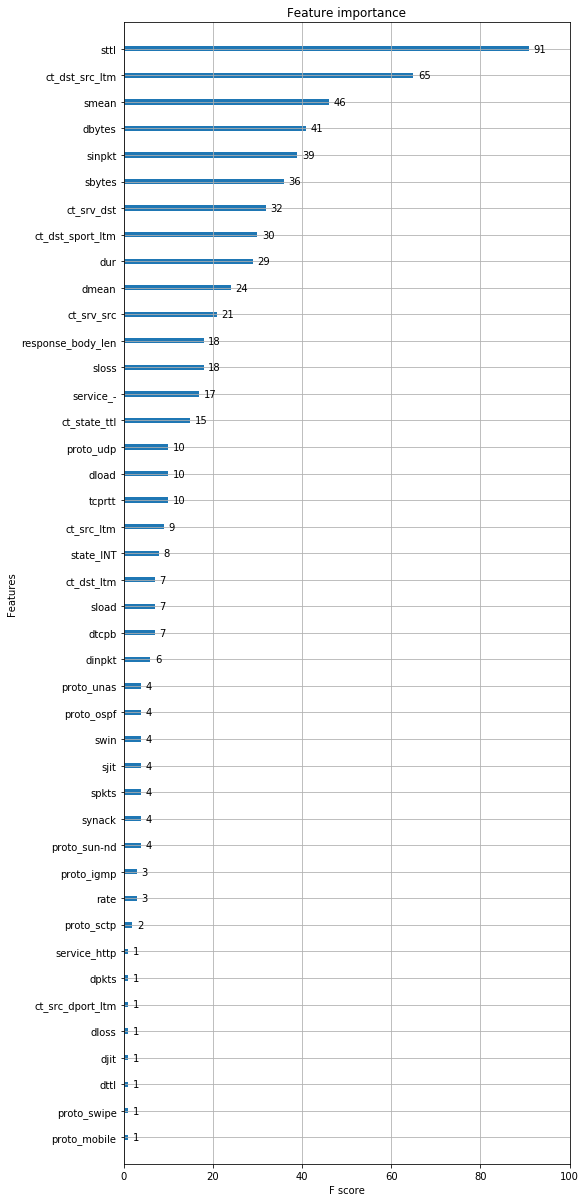

In [168]:
# also a plotting function, it uses weight by default, which is why it is not very useful!
fig, ax = plt.subplots(1,1,figsize=(8,21))
xgboost.plot_importance(XGB, ax=ax)

Feature importance plot. The feature 'sttl' carries the most weight for the classification.

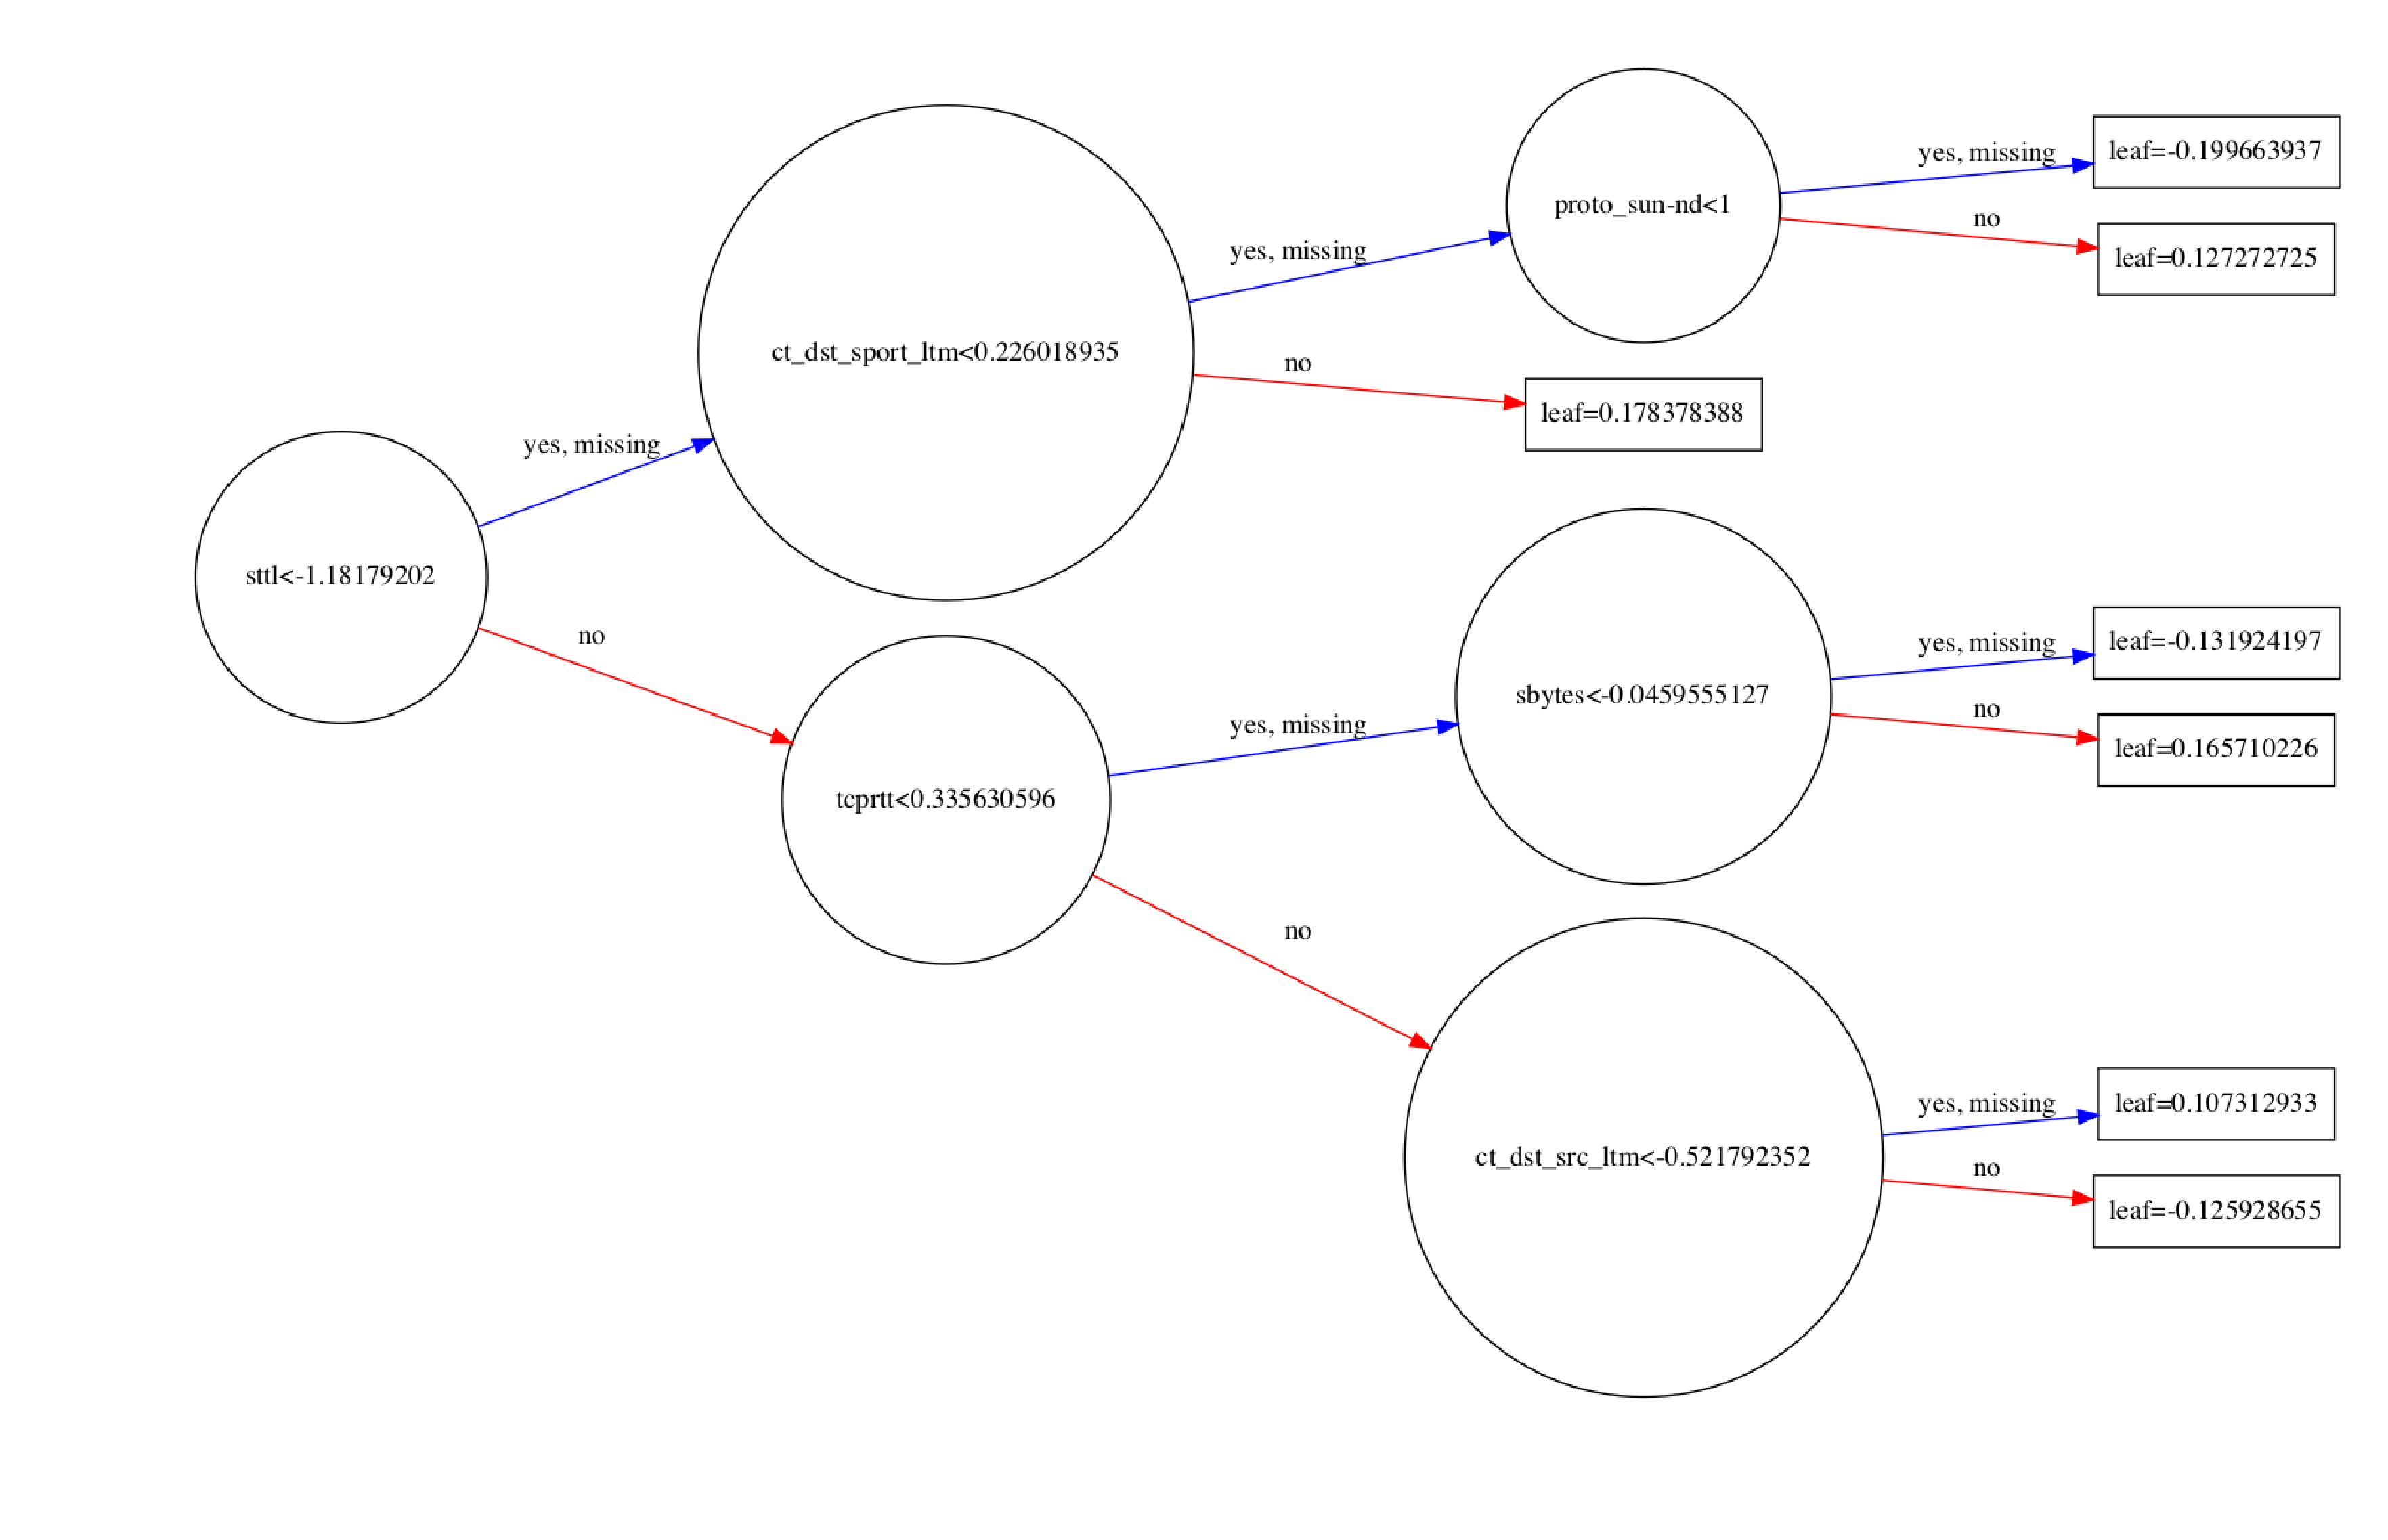

In [170]:

def visualize_tree_splitting(tree_model):
    fig = plt.figure(dpi=600)
    ax = plt.subplot(1,1,1)
    plot_tree(tree_model, num_trees=0, ax = ax,rankdir='LR')
    plt.tight_layout()
    plt.savefig("xgb_tree.pdf")
    plt.show()

    #This tree is one of several trees. XGBOOST uses ensemble for final 
    #classification. Thus the tree shown below sometime doesn't seem to be
    #optimum 

XGBOOST tree splitting. Note that, it is one instance of the weak lerner. Therefore, someting splitting doesnt make a lot of sense. 

In [136]:
def find_optimal_num_of_features(X,y):
    '''
    Input: Data Frames X and y : X is feature matrix, y is target
    Finds optimal number of features
    Answers this question
    "Actually how many features are required for reasonable classification accuracy?"
    RFECV() method answers the question.
    
    
    However, it is very-very slow process for most of the data. 
    ''' 
    # The "accuracy" scoring is proportional to the number of correct classifications
    rf_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=401, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=1.0) 
    rfecv = RFECV(estimator=rf_clf, step=1, cv=3,scoring='accuracy',n_jobs=4)   #3-fold cross-validation
    rfecv = rfecv.fit(X, y)

    print('Optimal number of features :', rfecv.n_features_)
    print('List of best features :', X.columns[rfecv.support_])

    # Plot number of features VS. cross-validation scores
    
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score: number of selected features")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
#find_optimal_num_of_features(feat_mat, target)

## Result <a id="result"></a>

Supervised classification algorithm, XGBoost, has been applied to  UNSW_NB15 to classify Normal versul Not-Normal traffic. Classifier does pretty good job of classifying the events with above 98% accuracy. To attain the accuracy many other features such as feature importance, grid-search etc are used. 